# Generative Adversarial Network

In [1]:
%matplotlib inline

import pickle as pkl
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

## Hyperparameters

In [2]:
class Hyperparameters:
    
    def __init__(self):
        # Size of latent vector to generator
        self.z_size = 100
        
        # Size of input image to discriminator
        self.input_size = 784 # 28x28 MNIST images flattened

        # Sizes of hidden layers in generator and discriminator
        self.g_hidden_size = 128
        self.d_hidden_size = 128
        
        # Leak factor for leaky ReLU
        self.alpha = 0.01
        
        # Label smoothing factor
        self.smooth = 0.1
        
        # Learning rate
        self.learning_rate = 0.002
        
        # Batch size
        self.batch_size = 100
        
        # Training epochs
        self.epochs = 100
        
        
    def print_params(self):
        print('z_size        = {}'.format(self.z_size))
        print('input_size    = {}'.format(self.input_size))
        print('g_hidden_size = {}'.format(self.g_hidden_size))
        print('d_hidden_size = {}'.format(self.d_hidden_size))
        print('alpha         = {}'.format(self.alpha))
        print('smooth        = {}'.format(self.smooth))
        print('learning_rate = {}'.format(self.learning_rate))
        print('batch_size    = {}'.format(self.batch_size))
        print('epochs        = {}'.format(self.epochs))

In [3]:
hp = Hyperparameters()

hp.print_params()

z_size        = 100
input_size    = 784
g_hidden_size = 128
d_hidden_size = 128
alpha         = 0.01
smooth        = 0.1
learning_rate = 0.002
batch_size    = 100
epochs        = 100


## Extracting Data

In [4]:
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Building GAN Model

In [5]:
class GAN:
    
    def __init__(self):
        # Input placeholder for generator
        self.inputs_z = None
        
        # Input placeholder for discriminator
        self.inputs_real = None
        
        # Generator output
        self.g_model = None
    
        # Discriminator output and logits for real images
        self.d_model_real = None
        self.d_logits_real = None
        
        # Discriminator output and logits for fake images
        self.d_model_fake = None
        self.d_logits_fake = None
        
        # Generator loss and optimizer
        self.g_loss = None
        self.g_train_opt = None
        
        # Discriminator loss and optimizer
        self.d_loss = None
        self.d_train_opt = None
        
        # Generator variables
        self.g_vars = None
        
        # Discriminator variables
        self.d_vars = None
        
    
    def print_gan(self):
        print('inputs_z: {}'.format(self.inputs_z))
        print('inputs_real: {}'.format(self.inputs_real))
        print('')
        print('g_model: {}'.format(self.g_model))
        print('')
        print('d_model_real: {}'.format(self.d_model_real))
        print('d_logits_real: {}'.format(self.d_logits_real))
        print('')
        print('d_model_fake: {}'.format(self.d_model_fake))
        print('d_logits_fake: {}'.format(self.d_logits_fake))
        print('')
        print('g_loss: {}'.format(self.g_loss))
        print('g_train_opt: {}'.format(self.g_train_opt))
        print('')
        print('d_loss: {}'.format(self.d_loss))
        print('d_train_opt: {}'.format(self.d_train_opt))
        print('g_vars: {}'.format(self.g_vars))
        print('')
        print('d_vars: {}'.format(self.d_vars))

In [6]:
class GANBuilder:
    
    def create_input_placeholders(self, z_dim, real_dim):
        '''
        Create input placeholders.
        
        Arguments
        ---------
        z_dim : Shape of input to generator
        real_dim : Shape of input to discriminator
        
        Returns
        -------
        inputs_z, inputs_real : Input placeholders for generator and discriminator
        '''
        # Generator input
        inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
        
        # Discriminator input
        inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
        
        return inputs_z, inputs_real
    

    def generator(self, z, out_dim, n_units=128, reuse=False, alpha=0.01):
        ''' 
        Build the generator network.

        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU

        Returns
        -------
        out : Tanh output
        '''
        with tf.variable_scope('generator', reuse=reuse):
            # Hidden layer
            h1 = tf.layers.dense(z, n_units, activation=None)
            # Leaky ReLU
            h1 = tf.maximum(alpha * h1, h1)

            # Logits and tanh output
            logits = tf.layers.dense(h1, out_dim, activation=None)
            out = tf.tanh(logits)
            
            return out

        
    def discriminator(self, x, n_units=128, reuse=False, alpha=0.01):
        ''' 
        Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits : Sigmoid output and logits
        '''
        with tf.variable_scope('discriminator', reuse=reuse):
            # Hidden layer
            h1 = tf.layers.dense(x, n_units, activation=None)
            # Leaky ReLU
            h1 = tf.maximum(alpha * h1, h1)
            
            # Logits and simoid output
            logits = tf.layers.dense(h1, 1, activation=None)
            out = tf.sigmoid(logits)
            
            return out, logits
    
    
    def create_loss_functions(self, d_logits_real, d_logits_fake, smooth):
        '''
        Create loss functions for generator and discriminator.
        
        Arguments
        ---------
        d_logits_real : Discriminator logits for real images
        d_logits_fake : Discriminator logits for fake images
        smooth : Smoothing factor
        
        Returns
        -------
        g_loss, d_loss : Loss functions for generator and discriminator
        '''
        g_loss = self.compute_loss(d_logits_fake,
                                   tf.ones_like(d_logits_fake))
        
        d_loss_real = self.compute_loss(d_logits_real,
                                        tf.ones_like(d_logits_real)*(1-smooth))
        d_loss_fake = self.compute_loss(d_logits_fake,
                                        tf.zeros_like(d_logits_real))
        
        d_loss = d_loss_real + d_loss_fake
        
        return g_loss, d_loss
    
        
    def compute_loss(self, logits, labels):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                      labels=labels))
    
    def create_optimizers(self, g_loss, d_loss):
        '''
        Create optimizers for generator and discriminator.
        
        Arguments
        ---------
        g_loss : Generator loss function
        d_loss : Discriminator loss function
        
        Returns
        -------
        g_train_opt, d_train_opt, g_vars, d_vars : Optimizers and scoped variables
        '''
        t_vars = tf.trainable_variables()
        
        g_vars = [t_var for t_var in t_vars if t_var.name.startswith('generator')]
        d_vars = [t_var for t_var in t_vars if t_var.name.startswith('discriminator')]

        g_train_opt = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
        
        return g_train_opt, d_train_opt, g_vars, d_vars

In [7]:
class GANGraphBuilder:
    
    def build_gan_graph(self, hp):
        '''
        Build GAN model with generator and discriminator networks.
        
        Arguments
        ---------
        hp : Hyperparameters

        Returns
        -------
        gan, gan_graph : GAN and TF graph
        '''
        
        tf.reset_default_graph()
        
        gan_graph = tf.Graph()
        
        gan = GAN()
        ganBuilder = GANBuilder()
        
        with gan_graph.as_default():
            
            # Create input placeholders
            gan.inputs_z, gan.inputs_real = ganBuilder.create_input_placeholders(hp.z_size, 
                                                                               hp.input_size)
            
            # Build generator network
            gan.g_model = ganBuilder.generator(gan.inputs_z, 
                                               out_dim=hp.input_size,
                                               n_units=hp.g_hidden_size,
                                               alpha=hp.alpha)
            
            # Build discriminator network
            gan.d_model_real, gan.d_logits_real = ganBuilder.discriminator(gan.inputs_real,
                                                                           hp.d_hidden_size,
                                                                           False,
                                                                           hp.alpha)
            
            gan.d_model_fake, gan.d_logits_fake = ganBuilder.discriminator(gan.g_model,
                                                                           hp.d_hidden_size,
                                                                           True,
                                                                           hp.alpha)
            
            # Get loss functions
            gan.g_loss, gan.d_loss = ganBuilder.create_loss_functions(gan.d_logits_real, 
                                                                      gan.d_logits_fake, 
                                                                      hp.smooth)
            
            # Get optimizers
            gan.g_train_opt, gan.d_train_opt, gan.g_vars, gan.d_vars = \
                ganBuilder.create_optimizers(gan.g_loss, gan.d_loss)
            
            return gan, gan_graph

In [10]:
ganGraphBuilder = GANGraphBuilder()

gan, gan_graph = ganGraphBuilder.build_gan_graph(hp)

gan.print_gan()

inputs_z: Tensor("input_z:0", shape=(?, 100), dtype=float32)
inputs_real: Tensor("input_real:0", shape=(?, 784), dtype=float32)

g_model: Tensor("generator/Tanh:0", shape=(?, 784), dtype=float32)

d_model_real: Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
d_logits_real: Tensor("discriminator/dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)

d_model_fake: Tensor("discriminator_1/Sigmoid:0", shape=(?, 1), dtype=float32)
d_logits_fake: Tensor("discriminator_1/dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)

g_loss: Tensor("Mean:0", shape=(), dtype=float32)
g_train_opt: name: "Adam"
op: "NoOp"
input: "^Adam/update_generator/dense/kernel/ApplyAdam"
input: "^Adam/update_generator/dense/bias/ApplyAdam"
input: "^Adam/update_generator/dense_1/kernel/ApplyAdam"
input: "^Adam/update_generator/dense_1/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"


d_loss: Tensor("add:0", shape=(), dtype=float32)
d_train_opt: name: "Adam_1"
op: "NoOp"
input: "^Adam_1/update_discr

## Training GAN Model

In [11]:
class ModelTrainer:
    
    def train_gan_model(self, mnist, gan, gan_graph, hp):
        saver = tf.train.Saver(var_list=gan.g_vars)
        
        losses = []
        samples = []
        
        ganBuilder = GANBuilder()
        
        with tf.Session(graph=gan_graph) as sess:
            sess.run(tf.global_variables_initializer())
            
            for e in range(hp.epochs):
                n_batches = mnist.train.num_examples//hp.batch_size
                
                for ii in range(n_batches):
                    batch = mnist.train.next_batch(hp.batch_size)
                    
                    # Get images, reshape and rescale to pass to discriminator
                    batch_images = batch[0].reshape((hp.batch_size, hp.input_size))
                    batch_images = batch_images*2 - 1
                    
                    # Sample random noise for generator
                    batch_z = np.random.uniform(-1, 1, size=(hp.batch_size, hp.z_size))
                    
                    # Run optimizers
                    _ = sess.run(gan.d_train_opt,
                                 feed_dict={gan.inputs_real: batch_images,
                                            gan.inputs_z: batch_z})
                
                    _ = sess.run(gan.g_train_opt,
                                 feed_dict={gan.inputs_z: batch_z})
                    
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(gan.d_loss,
                                        feed_dict={gan.inputs_z: batch_z,
                                                   gan.inputs_real: batch_images})
                train_loss_g = gan.g_loss.eval({gan.inputs_z: batch_z})

                print("Epoch {}/{}...".format(e+1, hp.epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))        

                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))

                # Sample from generator as we're training for viewing afterwards
                sample_z = np.random.uniform(-1, 1, size=(16, hp.z_size))
                g_model = ganBuilder.generator(gan.inputs_z, 
                                               hp.input_size, 
                                               hp.g_hidden_size, 
                                               True, 
                                               hp.alpha)
                gen_samples = sess.run(g_model,
                                       feed_dict={gan.inputs_z: sample_z})
                samples.append(gen_samples)

                saver.save(sess, 'checkpoints')

        # Save training losses and generator samples
        PickleHelper().save_training_data((losses, samples))

In [12]:
class PickleHelper:
    
    def save_training_data(self, data):
        """
        Save parameters to file.
        """
        pkl.dump(data, open('train_data.pkl', 'wb'))
    
    def load_training_data(self):
        """
        Load parameters from file.
        """
        return pkl.load(open('train_data.pkl', 'rb'))

In [13]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [14]:
modelTrainer = ModelTrainer()

modelTrainer.train_gan_model(mnist, gan, gan_graph, hp)

Epoch 1/100... Discriminator Loss: 0.3613... Generator Loss: 3.8363
Epoch 2/100... Discriminator Loss: 1.3835... Generator Loss: 1.4575
Epoch 3/100... Discriminator Loss: 0.3555... Generator Loss: 3.9127
Epoch 4/100... Discriminator Loss: 0.3931... Generator Loss: 3.6746
Epoch 5/100... Discriminator Loss: 0.6685... Generator Loss: 3.6875
Epoch 6/100... Discriminator Loss: 0.5994... Generator Loss: 3.9257
Epoch 7/100... Discriminator Loss: 0.9362... Generator Loss: 2.0954
Epoch 8/100... Discriminator Loss: 0.5843... Generator Loss: 3.0880
Epoch 9/100... Discriminator Loss: 0.5220... Generator Loss: 3.3542
Epoch 10/100... Discriminator Loss: 0.8279... Generator Loss: 2.6348
Epoch 11/100... Discriminator Loss: 0.8003... Generator Loss: 2.5099
Epoch 12/100... Discriminator Loss: 0.8899... Generator Loss: 2.2348
Epoch 13/100... Discriminator Loss: 0.9045... Generator Loss: 2.6355
Epoch 14/100... Discriminator Loss: 0.6311... Generator Loss: 4.4729
Epoch 15/100... Discriminator Loss: 1.0435.

## Viewing Training Loss

In [15]:
class TrainingLossDisplayer:
    
    def show_training_loss(self, losses):
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator')
        plt.plot(losses.T[1], label='Generator')
        plt.title("Training Losses")
        plt.legend()

In [16]:
losses, samples = PickleHelper().load_training_data()

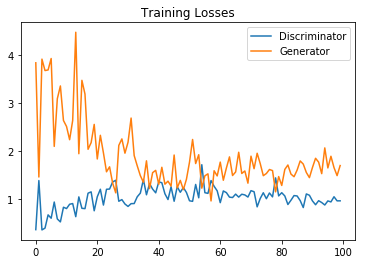

In [17]:
trainingLossDisplayer = TrainingLossDisplayer()

trainingLossDisplayer.show_training_loss(losses)

## Viewing Sample Images from Generator

In [18]:
class ImageDisplayer:

    def show_samples(self, epoch, samples):
        fig, axes = plt.subplots(figsize=(7,7), 
                                 nrows=4, ncols=4, 
                                 sharey=True, sharex=True)

        for ax, img in zip(axes.flatten(), samples[epoch]):
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

        return fig, axes
    
    def show_samples_by_interval(self, samples):
        rows, cols = 10, 6
        
        fig, axes = plt.subplots(figsize=(7,12), 
                                 nrows=rows, ncols=cols, 
                                 sharex=True, sharey=True)

        for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
            for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
                ax.imshow(img.reshape((28,28)), cmap='Greys_r')
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)

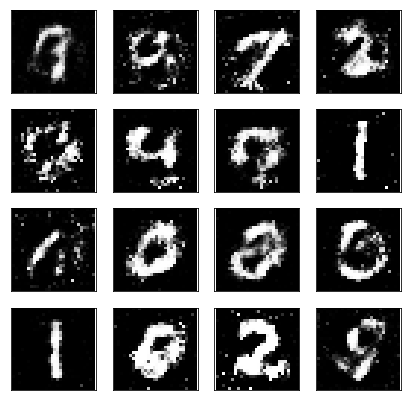

In [19]:
imageDisplayer = ImageDisplayer()

_ = imageDisplayer.show_samples(-1, samples)

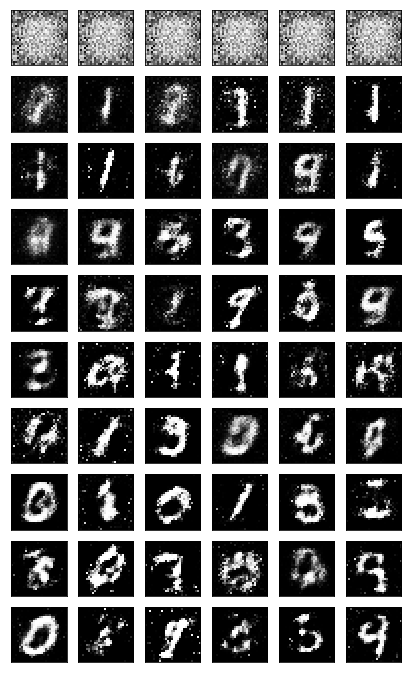

In [20]:
imageDisplayer.show_samples_by_interval(samples)

## Generating New Sample Images

In [21]:
class ImageGenerator:
    
    def generate_and_show_images(self, gan, gan_graph, hp):
        saver = tf.train.Saver(var_list=gan.g_vars)
        
        ganBuilder = GANBuilder()
        imageDisplayer = ImageDisplayer()
        
        with tf.Session(graph=gan_graph) as sess:
            saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
            
            sample_z = np.random.uniform(-1, 1, size=(16, hp.z_size))
            g_model = ganBuilder.generator(gan.inputs_z, 
                                           hp.input_size, 
                                           hp.g_hidden_size, 
                                           True, 
                                           hp.alpha)
            
            gen_samples = sess.run(g_model,
                                   feed_dict={gan.inputs_z: sample_z})
            
        imageDisplayer.show_samples(0, [gen_samples])

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


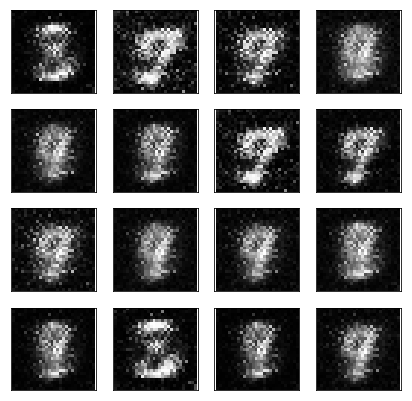

In [22]:
imageGenerator = ImageGenerator()

imageGenerator.generate_and_show_images(gan, gan_graph, hp)